In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from graphviz import Digraph
import math
import random

In [217]:
class Value:
    
    def __init__(self, data, _children = (), _op = '', label = ''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.grad = 0.0
        self.label = label
        self._backward = lambda: None
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self,other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __pow__(self,x):
        assert isinstance(x, (int,float))
        out = Value(self.data ** x, (self,), 'pow')
        def _backward():
            self.grad += out.grad * (x * self.data ** (x-1))
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/ (math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
    
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    
    def __radd__(self,other):
        return self+other
    
    def __rmul__(self, other):
        return self * other
    
    def __rsub__(self, other):
        return self - other
    
    def __neg__(self):
        return self * (-1)
    
    def __sub__(self, other):
        return self + (-other)

In [218]:
class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
        
    def __call__(self,x):
        act = sum([w1*x1 for w1,x1 in zip(self.w, x)]) + self.b
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

In [219]:
class Layer:
    
    def __init__(self,nin,nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self,x):
        out = [l(x) for l in self.neurons]
        return out[0] if len(out) == 1 else out
    
    def parameters(self):
        return [p for l in self.neurons for p in l.parameters()]

In [220]:
class MLP:
    
    def __init__(self,nin,nouts):
        temp = [nin] + nouts
        self.layers = [Layer(temp[i],temp[i+1]) for i in range(len(nouts))]
        
    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for l in self.layers for p in l.parameters()]

In [221]:
model = MLP(3,[4,4,1])
inp = [3,-1,0.5]
model(inp)

Value(data=-0.5452685984144237)

In [223]:
xs = [
    [2,1,1],
    [4,-0.5,1.5],
    [1.5,2,2]
]
ys = [1,-1,-1]

In [233]:
y_pred = [model(t) for t in xs]
y_pred

[Value(data=0.9348606837712633),
 Value(data=-0.9412755974837597),
 Value(data=-0.9435099022022373)]

In [232]:
for i in range(10):
    # Getting predictions
    y_pred = [model(t) for t in xs]
    
    #Writing loss function
    loss = sum([(yt - yh)**2 for yh,yt in zip(y_pred, ys)])
    
    #zero_grad
    for p in model.parameters():
        p.grad = 0
    
    #backpropogate loss
    loss.backward()
    
    #update parameters
    for p in model.parameters():
        p.data -= 0.1 * p.grad
    print(loss)

Value(data=0.013054867619843147)
Value(data=0.012802804361205823)
Value(data=0.012559533324958728)
Value(data=0.012324617645148386)
Value(data=0.01209764837549173)
Value(data=0.011878242322089283)
Value(data=0.011666040073118349)
Value(data=0.011460704205074109)
Value(data=0.011261917647498483)
Value(data=0.011069382190207856)


In [63]:
a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')
e = a*b; e.label = 'e'
d = a+c; d.label = 'd'
f = Value(0.2, label ='f')
L = d*f; L.label = 'L'
e = L.tanh(); e.label = 'e'

In [64]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

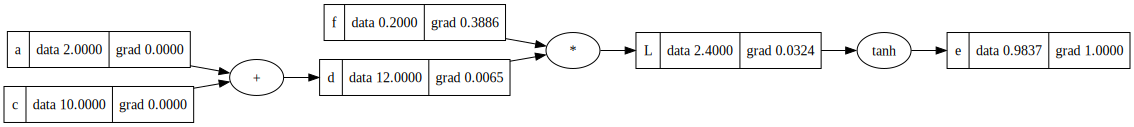

In [70]:
draw_dot(e)

In [66]:
e.grad = 1

In [67]:
e._backward()

In [69]:
L._backward()